# <u>Bot Detection</u>

# 1. Data Collection and Integration

## 1.1. Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import os,glob,sys,nltk
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold

## 1.2. Globals

In [2]:
DATASETS_DIR = 'Datasets'
SRC_DIR = 'src'
TWEETS_DIR = 'Tweets'
BOT_TWEETS_DIR = 'Bot_accounts_tweets'
GENUINE_TWEETS_DIR = 'Genuine_accounts_tweets'

In [3]:
# for organized printing only
class txt_format:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## 1.3. Loading Data and Modules

In [4]:
# genuine users => 0 , bots => 1
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, DATASETS_DIR)
os.chdir(dataset_dir)
# Loading users data
total_data = pd.DataFrame()
for File_Name in glob.glob("*_users.csv"):
    df = pd.read_csv(File_Name)
    if File_Name == 'genuine_accounts_users.csv':
        df['bot'] = 0
    elif File_Name == 'E13_users.csv' or File_Name == 'TFP_users.csv':
        df['bot'] = 0
        df['test_set_1'] = 0
        df['test_set_2'] = 0
    elif File_Name == 'fake_followers_users.csv':
        df['bot'] = 1
    elif 'social_spambots' in File_Name:
        df['bot'] = 1
    elif 'traditional_spambots' in File_Name:
        df['bot'] = 1
    else:
        print(File_Name)
    total_data = pd.concat([total_data,df], ignore_index = True)

os.chdir(cwd)

### 1.3.1. Loading Tweets and Description

'run_full_process' is a binary variable that decides wheather running all notebooks cells will take a few hours. If marked with 1, will run:
* translation process using Yandex service - also limited by characters per day
* language detection process using Yandex service - also limited by characters per day
* BoW process
* finding most important words in description text field
* calculating the tweet features (including the variation on Levenshtein distances. Takes some time)

otherwise, will skip it and use pre-made files.

In [5]:
run_full_process = 0

In [6]:
user_data_file_path = os.path.join(dataset_dir, 'tweet_features_filled1.csv')
user_data = pd.read_csv(user_data_file_path)
user_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
levenshtein_data_file_path = os.path.join(dataset_dir, 'tweet_var_data_full_with_threshold.csv')
levenshtein_data = pd.read_csv(levenshtein_data_file_path)

In [8]:
if(not run_full_process):
    description_data_file_path = os.path.join(dataset_dir, 'description_data_set2.csv')
    description_df = pd.read_csv(description_data_file_path)

In [9]:
if(not run_full_process):
    count_vectors_df = pd.DataFrame()
    count_vectors_files_names = [file 
                                 for file in os.listdir(dataset_dir) 
                                 if os.path.isfile(os.path.join(dataset_dir, file)) and 
                                 'count_df_' in file
                                ]
    
    for count_vectors_file_name in count_vectors_files_names:
        count_vectors_data_file_path = os.path.join(dataset_dir, count_vectors_file_name)
        count_df = pd.read_csv(count_vectors_data_file_path)
        count_vectors_df = pd.concat([count_vectors_df,count_df], ignore_index = True)
    count_vectors_df.drop('Unnamed: 0.1', axis=1, inplace=True)

### 1.3.2.  Loading Modules

In [10]:
modules_path = os.path.join(os.getcwd(),SRC_DIR)
if modules_path not in sys.path:
    sys.path.append(modules_path)

## 1.4. Data Undestanding

In [11]:
# understanding data types
total_data.dtypes

bot                                     int64
contributors_enabled                  float64
crawled_at                             object
created_at                             object
dataset                                object
default_profile                       float64
default_profile_image                 float64
description                            object
favourites_count                        int64
follow_request_sent                   float64
followers_count                         int64
following                             float64
friends_count                           int64
geo_enabled                           float64
id                                      int64
is_translator                         float64
lang                                   object
listed_count                            int64
location                               object
name                                   object
notifications                         float64
profile_background_color          

In [12]:
#training size:
len(total_data.index)

16318

In [13]:
total_data.head(10)

,bot,contributors_enabled,crawled_at,created_at,dataset,default_profile,default_profile_image,description,favourites_count,follow_request_sent,...,screen_name,statuses_count,test_set_1,test_set_2,time_zone,timestamp,updated,url,utc_offset,verified
0,0,NaN,NaN,Fri Apr 06 10:58:22 +0000 2007,E13,NaN,NaN,Founder of http://www.screenweek.it & http://w...,145,NaN,...,braddd,20370,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://braddd.tumblr.com,3600.0,NaN
1,0,NaN,NaN,Mon Apr 30 15:08:42 +0000 2007,E13,NaN,NaN,BSc degree (cum laude) in Computer Engineering...,9,NaN,...,eKoeS,3131,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://www.lineheight.net/,3600.0,NaN
2,0,NaN,NaN,Tue May 01 11:53:40 +0000 2007,E13,NaN,NaN,Cogito ergo bestemmio.,323,NaN,...,tacone_,4024,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://t.co/LKrl1dZE,3600.0,NaN
3,0,NaN,NaN,Tue May 15 16:55:16 +0000 2007,E13,NaN,NaN,"Se la vita ti dà sarde, scapocciale!",1118,NaN,...,alesstar,40586,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://alesstar.wordpress.com/,3600.0,NaN
4,0,NaN,NaN,Sun May 13 19:52:00 +0000 2007,E13,NaN,NaN,Je me souviens,13,NaN,...,PerDiletto,2016,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://www.flickr.com/per_diletto,3600.0,NaN
5,0,NaN,NaN,Fri May 18 15:16:20 +0000 2007,E13,NaN,NaN,"Swiper non rubare, Swiper non rubare!",53,NaN,...,crispaol,3603,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,NaN,3600.0,NaN
6,0,NaN,NaN,Fri May 18 10:28:11 +0000 2007,E13,NaN,NaN,I never saw a wild thing sorry for itself.A sm...,2,NaN,...,tmpx,1183,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,NaN,3600.0,NaN
7,0,NaN,NaN,Fri Jun 08 23:55:44 +0000 2007,E13,NaN,NaN,La vita è quello che accade mentre sei impegna...,597,NaN,...,Igor99,6194,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,NaN,3600.0,NaN
8,0,NaN,NaN,Sun Jun 24 07:49:50 +0000 2007,E13,NaN,NaN,Founder e CEO di http://hagakure.it e autore d...,590,NaN,...,marcomassarotto,10962,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,http://marcomassarotto.com,3600.0,NaN
9,0,NaN,NaN,Sat Jul 14 13:31:20 +0000 2007,E13,NaN,NaN,"Sono timido come Sushi, pigro come Dado e russ...",693,NaN,...,personanormale,10947,0.0,0.0,Rome,NaN,2015-02-14 10:54:49,NaN,3600.0,NaN


In [14]:
# # of basic user features (including target)
total_data.columns.size

44

### 1.4.1. Perliminary Data Visualization and Statistics

#### 1.4.1.1. Class Distribution

In [15]:
total_data['bot'].value_counts()

1    10894
0     5424
Name: bot, dtype: int64

#### 1.4.1.2. Language Histogram

In [16]:
print ("-------------------------------")
print ("Histogram for 'lang'")
print ("-------------------------------")
print (total_data['lang'].value_counts())
print ("")

-------------------------------
Histogram for 'lang'
-------------------------------
en                    11950
it                     2577
es                      374
en-gb                   122
pt                       71
fr                       46
ru                       46
ja                       34
zh-tw                    17
tr                       16
de                       13
id                       12
ko                        9
nl                        7
ar                        4
en-GB                     4
zh-TW                     3
da                        2
Select Language...        2
zh-cn                     2
fil                       1
sv                        1
gl                        1
xx-lc                     1
pl                        1
en-AU                     1
el                        1
Name: lang, dtype: int64



# 2. Data Preparation and Cleaning

## 2.1. Unique Values
* id, screen_name are unique - **different value for each record**
* contributors_enabled, follow_request_sent , following , notifications - **zero unique values** (NULL)
* verified, protected, profile_use_background_image, profile_background_tile, is_translator, geo_enabled, default_profile, default_profile_image - **single unique value**

In [17]:
total_data.nunique()

bot                                       2
contributors_enabled                      0
crawled_at                             3823
created_at                            16233
dataset                                   2
default_profile                           1
default_profile_image                     1
description                            9945
favourites_count                       2632
follow_request_sent                       0
followers_count                        2175
following                                 0
friends_count                          2171
geo_enabled                               1
id                                    16318
is_translator                             1
lang                                     27
listed_count                            229
location                               4955
name                                  15711
notifications                             0
profile_background_color                867
profile_background_image_url    

### Remove columns with zero unique values (NULL values only )
* contributors_enabled 
* follow_request_sent 
* following 
* notifications 

In [18]:
for col_name in total_data.columns:
    if total_data[col_name].nunique() < 1:
        print('removing ', col_name)
        total_data.drop(col_name, axis = 1, inplace = True)

removing  contributors_enabled
removing  follow_request_sent
removing  following
removing  notifications


### Removing irrelevant columns : 
* dataset (dataset name) 
* crawled_at (date the data was crawled)

In [19]:
total_data.drop(['dataset','crawled_at'], axis = 1, inplace = True)

## 2.2. NULL Values

Visualizing NULL count for each column

In [20]:
import Missing_Values_Lib

In [21]:
try:
    import missingno as msno
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install missingno --user #see if need user flag in university
    import missingno as msno       

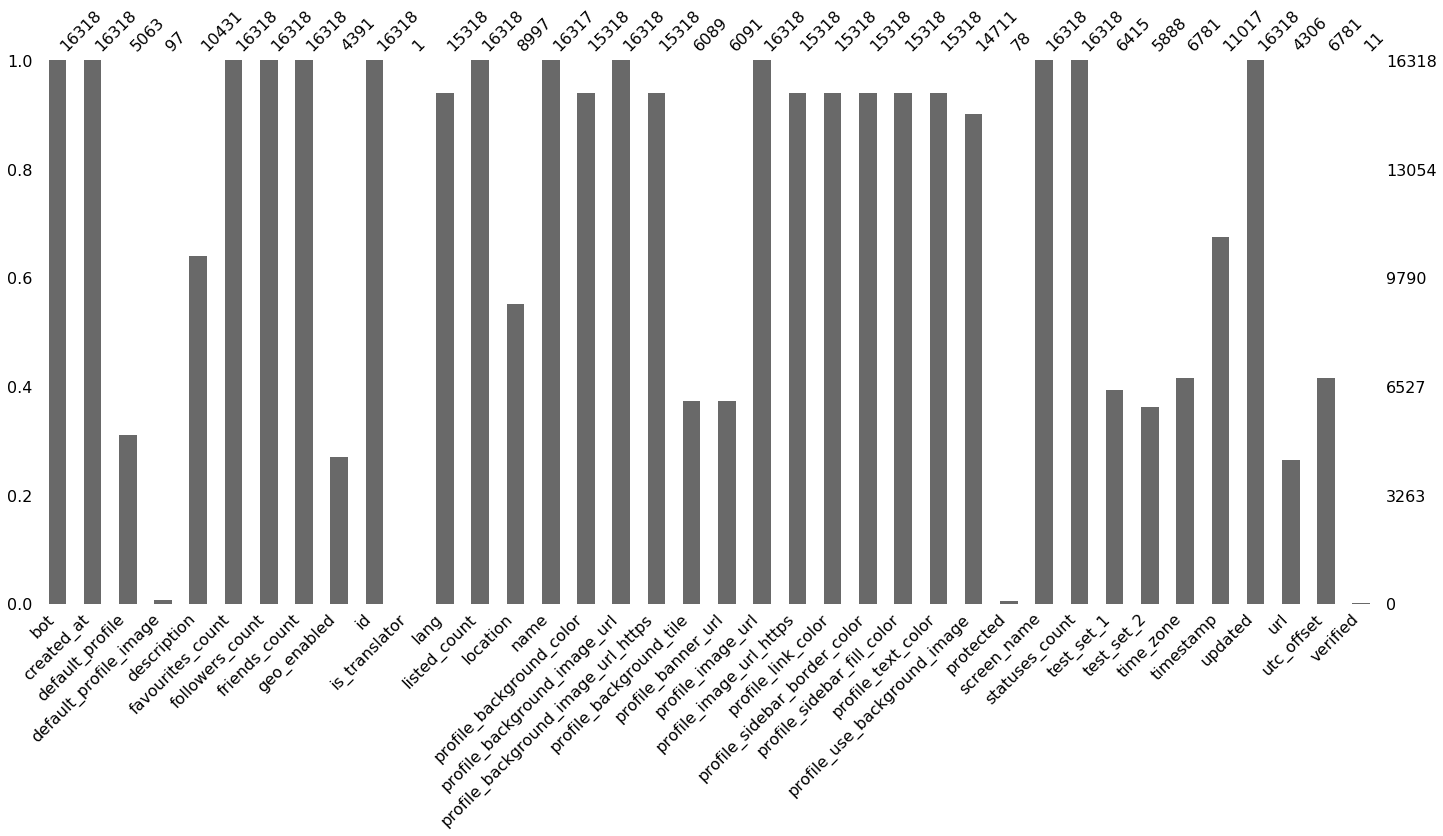

In [22]:
msno.bar(total_data)

In the graph above, each number represents the non-null count for a certain column

### Total missing values

In [23]:
np.sum(np.sum(total_data.isnull()))

188259

### Removing columns with more then 16,000 null values : 
* default_profile_image
* is_translator
* protected
* verified

In [24]:
threshold = 16000
for col_name in total_data.columns:
    if np.sum(total_data[col_name].isnull()) >= threshold:
        print('removing ', col_name)
        total_data.drop(col_name, axis = 1, inplace = True)

removing  default_profile_image
removing  is_translator
removing  protected
removing  verified


After understanding the data type in each column, we replace the Nulls with the appropriate value

In [25]:
Missing_Values_Lib.Fill_Missing(total_data)
np.sum(np.sum(total_data.isnull()))

0

This is a perliminary filling. More precise work will be done on feature engineering section.

# 3. Feature Engineering

## 3.1. Numeric Features

In [26]:
import General_Lib

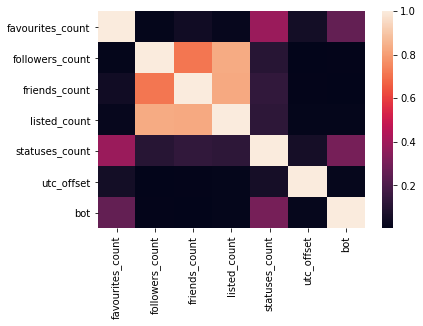

In [27]:
# The following features are the numeric features from user data (before engineering)
numeric_features_list = ['favourites_count',
                 'followers_count',
                 'friends_count',
                 'listed_count',
                 'statuses_count',
                 'utc_offset',
                 'bot']

corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, numeric_features_list)

**No apparent connection between main numeric features to the target**<br>
**We can see there is a high correlation between:**
1. listed_count - followers count 
2. listed_count - friends count 
3. friends count - followers count

In [28]:
corr_mtx['bot']

favourites_count    0.256424
followers_count     0.007785
friends_count       0.003983
listed_count        0.012425
statuses_count      0.303526
utc_offset          0.016984
bot                 1.000000
Name: bot, dtype: float64

**Each numeric feature is binned in order to get better correlation with the target feature on the following section. Features getting the highest correlation will replace current used features and will be added to the list below for future use:**

In [29]:
new_numeric_features = []

### 3.1.1. favourites_count

Text(0,0.5,'Count')

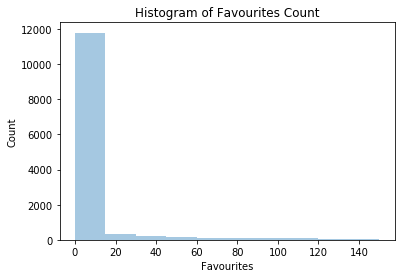

In [30]:
%matplotlib inline

sns.distplot(total_data[total_data.favourites_count<=150].favourites_count, bins = 10, kde = False)
plt.title('Histogram of Favourites Count')
plt.xlabel('Favourites')
plt.ylabel('Count')

**'0' has the highest frequency. We'll bin binarily if the value is 0 or not**

In [31]:
total_data['is_favourite'] = total_data['favourites_count'] > 0
print("new feature - target correlation is:",
      total_data['is_favourite'].corr(total_data['bot']))
print("old feature - target correlation is:",
        total_data['favourites_count'].corr(total_data['bot']))

new feature - target correlation is: -0.8213190694808825
old feature - target correlation is: -0.2564243618906531


In [32]:
new_numeric_features.append('is_favourite')

### 3.1.2. followers_count

Text(0,0.5,'Count')

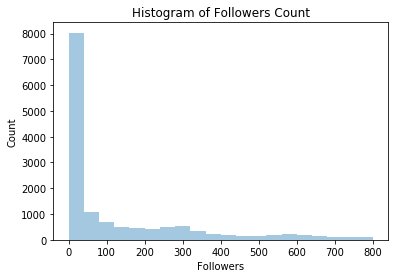

In [33]:
%matplotlib inline

sns.distplot(total_data[total_data.followers_count<=800].followers_count, bins = 20, kde = False)
plt.title('Histogram of Followers Count')
plt.xlabel('Followers')
plt.ylabel('Count')

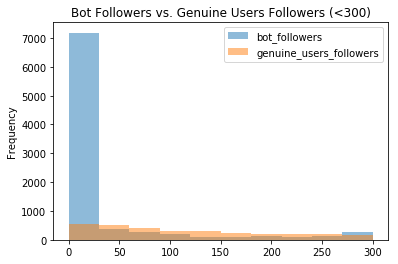

In [34]:
df_followers_count = total_data[total_data.followers_count<=300]
df_count = pd.DataFrame({'bot_followers': df_followers_count[df_followers_count.bot==1].followers_count,
                   'genuine_users_followers': df_followers_count[df_followers_count.bot==0].followers_count},
                   columns=['bot_followers', 'genuine_users_followers'])
plt.figure();
df_count.plot.hist(title = 'Bot Followers vs. Genuine Users Followers (<300)',bins= 10,alpha=0.5)  

In [35]:
print("Feature-target correlation:",total_data['followers_count'].corr(total_data['bot']))

Feature-target correlation: -0.007785367942083281


**Binning to 5 equal width buckets**

In [36]:
bin_followers_count= General_Lib.Binning(total_data['followers_count'],5)
print("Feature-target correlation:",bin_followers_count.corr(total_data['bot']))

Feature-target correlation: 0.002668162599855319


**Binning to 5 <u>un</u>equal width buckets**

In [37]:
total_data['bin_followers_count'] = General_Lib.Binning(total_data['followers_count'],
                                                        -1, 
                                                        bin_seq = [0,12,20,30,100,np.inf])

total_data.bin_followers_count = total_data.bin_followers_count.astype(int)
print("Feature-target correlation:",total_data['bin_followers_count'].corr(total_data['bot']))

Feature-target correlation: -0.5266178365117589


**We chose the bins by choosing the binning that maximizes the correlation to the target.**

Text(0,0.5,'Count')

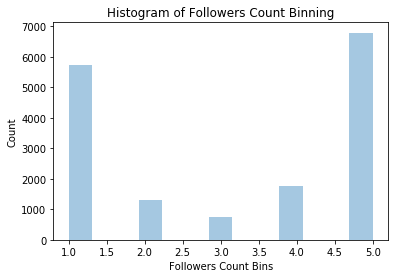

In [38]:
%matplotlib inline

sns.distplot(total_data['bin_followers_count'], kde = False)
plt.title('Histogram of Followers Count Binning')
plt.xlabel('Followers Count Bins')
plt.ylabel('Count')

In [39]:
new_numeric_features.append('bin_followers_count')

### 3.1.3. friends_count

Text(0,0.5,'Count')

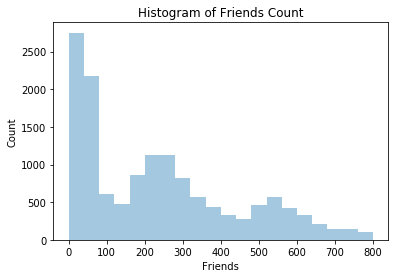

In [40]:
%matplotlib inline

sns.distplot(total_data[total_data.friends_count<=800].friends_count, bins = 20, kde = False)
plt.title('Histogram of Friends Count')
plt.xlabel('Friends')
plt.ylabel('Count')

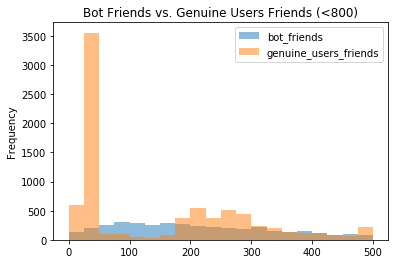

In [41]:
df_friends_count = total_data[total_data.friends_count<=500]
df_count = pd.DataFrame({'bot_friends': df_friends_count[df_friends_count.bot==0].friends_count,
                   'genuine_users_friends': df_friends_count[df_friends_count.bot==1].friends_count},
                   columns=['bot_friends', 'genuine_users_friends'])
plt.figure();
df_count.plot.hist(title = 'Bot Friends vs. Genuine Users Friends (<800)',bins= 20,alpha=0.5)                         

In [42]:
print("Feature-target correlation:",total_data['friends_count'].corr(total_data['bot']))

Feature-target correlation: 0.0039828901611110015


**Binning to 20 equal width buckets**

In [43]:
bin_friends_count = General_Lib.Binning(total_data['friends_count'],20)
print("Feature-target correlation:",bin_friends_count.corr(total_data['bot']))

Feature-target correlation: 0.0034724452602131967


**Binning to 5 <u>un</u>equal width buckets**

In [44]:
total_data['bin_friends_count'] = General_Lib.Binning(total_data['friends_count'],
                                                      -1, 
                                                      bin_seq = [0,2,10,50,90,np.inf])
print("Feature-target correlation:",total_data['bin_friends_count'].corr(total_data['bot']))

Feature-target correlation: -0.2963181531344163


In [45]:
total_data['bin_friends_count'].value_counts(dropna=False)

5    11223
3     4012
4      572
1      447
2       64
Name: bin_friends_count, dtype: int64

In [46]:
new_numeric_features.append('bin_friends_count')

### 3.1.4. listed_count

Text(0,0.5,'Count')

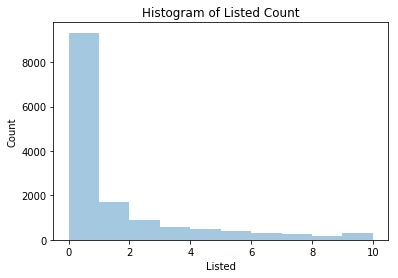

In [47]:
%matplotlib inline

sns.distplot(total_data[total_data.listed_count<=10].listed_count, bins = 10, kde = False)
plt.title('Histogram of Listed Count')
plt.xlabel('Listed')
plt.ylabel('Count')

In [48]:
print("Feature-target correlation:",total_data['listed_count'].corr(total_data['bot']))

Feature-target correlation: -0.012424547788108326


**Binary binning if the value of listed_count feature is zero or not** 

In [49]:
total_data['is_listed_count'] = total_data['listed_count'] > 0
print("Feature-target correlation:",total_data['is_listed_count'].corr(total_data['bot']))

Feature-target correlation: -0.33006426233526553


**Binning to 5 equal width buckets**

In [50]:
listed_count_binning = General_Lib.Binning(total_data['listed_count'],8)
print("Feature-target correlation:",listed_count_binning.corr(total_data['bot']))

Feature-target correlation: 0.003713323579452202


**Binning to 8 <u>un</u>equal width buckets**

In [51]:
total_data['listed_count_binning'] = General_Lib.Binning(total_data['listed_count'],
                                                         -1, 
                                                         bin_seq = [0,2,10,50,200,300,500,1000,np.inf])
total_data.listed_count_binning = total_data.listed_count_binning.astype(int)
print("Feature-target correlation:",total_data['listed_count_binning'].corr(total_data['bot']))

Feature-target correlation: -0.18992395104110327


In [52]:
new_numeric_features.append('is_listed_count')

### 3.1.5. statuses_count

Text(0,0.5,'Count')

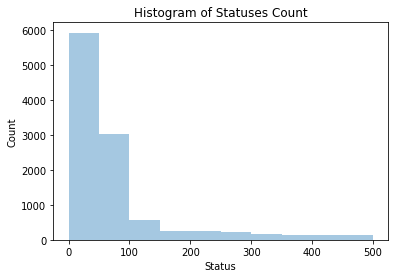

In [53]:
%matplotlib inline

sns.distplot(total_data[total_data.statuses_count<=500].statuses_count, bins = 10, kde = False)
plt.title('Histogram of Statuses Count')
plt.xlabel('Status')
plt.ylabel('Count')

In [54]:
print("Feature-target correlation:",total_data['statuses_count'].corr(total_data['bot']))

Feature-target correlation: -0.3035262516299992


**Binning to 3 unequal width buckets**

In [55]:
total_data['statuses_count_binning'] = General_Lib.Binning(total_data['statuses_count'],
                                                           -1, 
                                                           bin_seq = [0,80,300, np.inf])
total_data.statuses_count_binning = total_data.statuses_count_binning.astype(int)
print("Feature-target correlation:",total_data['statuses_count_binning'].corr(total_data['bot']))

Feature-target correlation: -0.7152237317990721


**Binning to 50 equal width buckets**

In [56]:
statuses_count_binning = General_Lib.Binning(total_data['statuses_count'],50)
print("Feature-target correlation:",statuses_count_binning.corr(total_data['bot']))

Feature-target correlation: -0.25368563083616547


**As we can see binning 3 buckets has given us great correlation to the target**

In [57]:
new_numeric_features.append('statuses_count_binning')

### 3.1.6. utc_offset

Text(0,0.5,'Count')

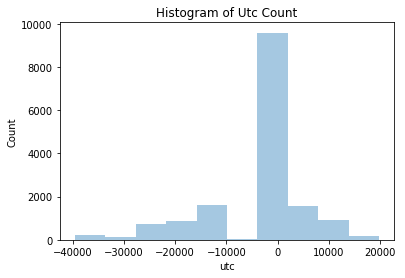

In [58]:
%matplotlib inline

sns.distplot(total_data[total_data.utc_offset<=20000].utc_offset, bins = 10, kde = False)
plt.title('Histogram of Utc Count')
plt.xlabel('utc')
plt.ylabel('Count')

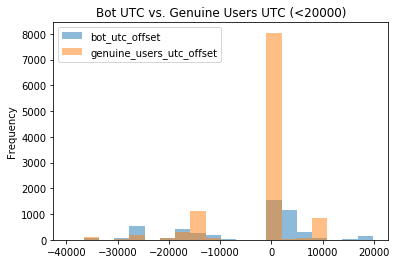

In [59]:
df_utc_offset = total_data[total_data.utc_offset<=20000]
df_count = pd.DataFrame({'bot_utc_offset': df_utc_offset[df_utc_offset.bot==0].utc_offset,
                   'genuine_users_utc_offset': df_utc_offset[df_utc_offset.bot==1].utc_offset},
                   columns=['bot_utc_offset', 'genuine_users_utc_offset'])
plt.figure();
df_count.plot.hist(title = 'Bot UTC vs. Genuine Users UTC (<20000)',bins= 20,alpha=0.5)                         

In [60]:
print("Feature-target correlation:",total_data['utc_offset'].corr(total_data['bot']))

Feature-target correlation: -0.016983652019355866


**Binning to 20 equal width buckets**

In [61]:
utc_offset_binning_1 = General_Lib.Binning(total_data['utc_offset'],20)
print("Feature-target correlation:",utc_offset_binning_1.corr(total_data['bot']))

Feature-target correlation: 0.03256158309843261


**Binning to 3 uequal width buckets**

In [62]:
utc_offset_binning_2 = General_Lib.Binning(total_data['utc_offset'],
                                           -1, 
                                           bin_seq = [-30000, 0, 10000, 20000])
print("Feature-target correlation:",utc_offset_binning_2.corr(total_data['bot']))

Feature-target correlation: -0.18487726729604453


**Binary binning if utc_offset is greater than zero or not**

In [63]:
total_data['is_utc_offset'] = total_data['utc_offset'] > 0
print("Feature-target correlation:",total_data['is_utc_offset'].corr(total_data['bot']))

Feature-target correlation: -0.36960636489833426


**Binary binning has provided the best correlation to the target**

In [64]:
new_numeric_features.append('is_utc_offset')

### 3.1.7. New Numeric Features Correlation

Correlation matrix of high correlated features

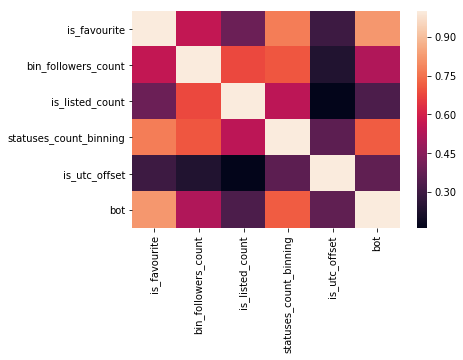

In [65]:
new_numeric_features.append('bot')
corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, new_numeric_features)

In [66]:
corr_mtx['bot']

is_favourite              0.821319
bin_followers_count       0.526618
is_listed_count           0.330064
statuses_count_binning    0.715224
is_utc_offset             0.369606
bot                       1.000000
Name: bot, dtype: float64

## 3.2. Date and Time

**Time and date features:** 
* created_at
* timestamp 
* updated 

We'll parse time and dates features to int features.

In [67]:
import Date_Parser_Lib

### 3.2.1. created_at feature

#### Created_at feature contains two date formats:
1. Day Month Day_in_month Hour:Minute:Seconds Time zone Year.
 * For example: Wed Jul 04 12:30:03 +0000 2007
2. Seconds from epoch
 * For example: 1183552203000L

**We will parse seconds from epoch format to the format described in bullet number 1. <br>
Then we will parse the updated feature to create new 7 numeric features:**
1. day of the week
2. month
3. day in month
4. hour
5. minute
6. second
7. year


In [68]:
feature_name = 'created_at'

**Check_For_Date_Format:** analyze the feature date format. <br>
<u>Return value: </u>
* seconds_from_epoch_data - samples contains seconds from epoch date format. <br>
* regular_date_format_data - all the remains samples.

In [69]:
seconds_from_epoch_data,regular_date_format_data = Date_Parser_Lib.Check_For_Date_Format(total_data, 
                                                                                         feature_name)

is all time stamp that does not contains +0000 are seconds from epoch format? True
Number of rows formatted as seconds from epoch: 1000
Number of rows formatted as regular date: 15318
is seconds from epoch + regular data = all data? True


#####  parse seconds from epoch date format 
* ignoring time zone (+0000 on every row).
* Convert seconds from epoch to regular date format
* Example of seconds from epoch date format: 1183552203000L

In [70]:
seconds_from_epoch_data['created_at'].head(5)

13687    1183552203000L
13688    1185440851000L
13689    1192725360000L
13690    1196614406000L
13691    1209536534000L
Name: created_at, dtype: object

**Convert seconds from epoch date format to regular format**

In [71]:
date_format_ceated_at = '%a %b %d %H:%M:%S +0000 %Y'
seconds_from_epoch_data[feature_name] = seconds_from_epoch_data[feature_name].apply(
                                        Date_Parser_Lib.convert_seconds_from_epoch_to_date_format,
                                        args = (date_format_ceated_at,))

seconds_from_epoch_data['created_at'].head(5)

13687    Wed Jul 04 12:30:03 +0000 2007
13688    Thu Jul 26 09:07:31 +0000 2007
13689    Thu Oct 18 16:36:00 +0000 2007
13690    Sun Dec 02 16:53:26 +0000 2007
13691    Wed Apr 30 06:22:14 +0000 2008
Name: created_at, dtype: object

**Concatenate the records**

In [72]:
total_data = pd.concat([seconds_from_epoch_data,regular_date_format_data])

**validate there is'nt any seconds from epoch format **

In [73]:
Date_Parser_Lib.Rows_Contain_Seconds_From_Epoch_Format(total_data,feature_name)

0

**Parse created_at column to create new numeric features**

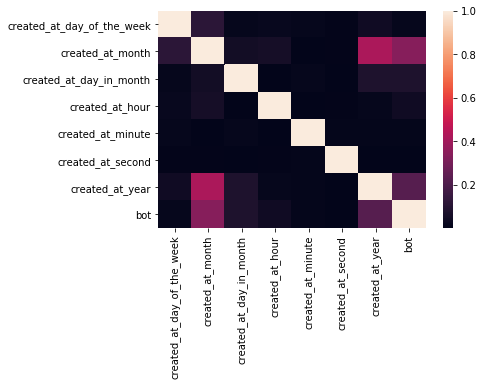

In [74]:
new_features_names,features_corr = Date_Parser_Lib.Parse_Feature_and_Print_Corr(total_data, 
                                                                  feature_name, 
                                                                  'bot', 
                                                                  date_format_ceated_at)

**New features correlation**

In [75]:
features_corr['bot']

created_at_day_of_the_week    0.013283
created_at_month              0.337823
created_at_day_in_month       0.081095
created_at_hour               0.041911
created_at_minute             0.010460
created_at_second             0.002967
created_at_year               0.226520
bot                           1.000000
Name: bot, dtype: float64

* **we cannot rely on the created year, as new bots created  all the time.**<br>
* **we will check the created_at_month feature<br>**
 * We assume maybe there is a connection between the created month to bot accounts <br>
* **There isn't a distinct connection between all the remains new features to the target feature.**

In [76]:
total_data[total_data['bot']==1]['created_at_month'].value_counts(dropna = False)

2     3217
3     2009
6     1468
1     1419
5      489
9      484
7      467
8      425
4      311
10     213
12     200
11     192
Name: created_at_month, dtype: int64

In [77]:
total_data[total_data['bot']==0]['created_at_month'].value_counts(dropna = False)

1     506
3     478
6     472
4     470
11    460
10    458
2     455
7     453
12    450
5     446
8     393
9     383
Name: created_at_month, dtype: int64

**February and March months are the most frequent months for bot accounts creation** <br>
**Binning according to those months**

In [78]:
total_data['is_february_march'] = (total_data['created_at_month'] == 2) | (total_data['created_at_month'] == 3)
print("Feature-target correlation:",total_data['is_february_march'].corr(total_data['bot']))

Feature-target correlation: 0.29902045981090875


**Binning according to top 4 months for bot accounts creation**

In [79]:
top_bot_months = [1,2,3,6]
total_data['is_top_month'] = total_data.apply(lambda x: 
                                              1 if x['created_at_month'] in top_bot_months 
                                              else 0,
                                             axis = 1)
print("Feature-target correlation:",total_data['is_top_month'].corr(total_data['bot']))

Feature-target correlation: 0.37974963107802034


**We managed to create new feature with correlation a little higher from the month feature. **

#### Remove created_at feature

In [80]:
total_data.drop([feature_name], axis = 1, inplace = True)

### 3.2.2. Updated column

**This column was added by the researchers and it is the same value at each dataset file.<br> 
We will remove this feature.**

In [81]:
total_data.drop(['updated'], axis = 1, inplace = True)

### 3.2.3. timestamp column

**This column was added by the researchers and isn't part of twitter's API.<br> 
We will remove this feature.**

In [82]:
total_data.drop(['timestamp'], axis = 1, inplace = True)

## 3.3. Textual User Features (without description)

 We devided the text features to 3 groups:
* Color features
* Location feature
* General text features

each group was treated in a slightly different way.

#### Text Features List

In [83]:
groups_types = total_data.columns.to_series().groupby(df.dtypes).groups
str_cols_names = [v 
                  for k, v in groups_types.items() 
                  if k.name == 'object'][0]

if 'profile_text_color' not in str_cols_names:
    str_cols_names = str_cols_names.append(pd.Index(['profile_text_color']))

print('{0}{1}{2}{3}{3}'.format(txt_format.BOLD,
                               txt_format.UNDERLINE,
                               'Text features:',
                               txt_format.END))

for col_name in str_cols_names:
    print(col_name)

Text features:
description
lang
location
name
profile_background_color
profile_background_image_url
profile_background_image_url_https
profile_banner_url
profile_image_url
profile_image_url_https
profile_link_color
profile_sidebar_border_color
profile_sidebar_fill_color
screen_name
time_zone
url
profile_text_color


### 3.3.1. General Text Features

For each general text feature we added 5 new numeric features:
* <u>Replace a string with unique value:</u> 
  * defined unique mapping from feature values to int and apply to the feature values.
* <u>Replace missing values by unique mapping by mode:</u>  
  * For the features created by the unique values, there are missing values (marked as enpty string). We will replace those values by mode. 
  * We split the mode replacment to two options: 
   * If all the nan values is of bot account: replace the missing values by the bot mode value of the feature.    
   * else replace by feature mode. 
* <u>Replace missing values by unique mapping by distribution:</u> 
 * same as for the mode case, only we replace the missing values from feature distribution. 
* <u>Binning by is most common:</u>  
 * For features we detected a single value that is the most common value, we created a new feature indicating if the sample contains the most common value or not.  
* <u>Replace a string with length:</u>
 * Replace each string with it's length.

In [84]:
import Text_Features_Lib


**Detect if all missing values is of bot account.**

In [85]:
def Is_All_Nan_of_Bot(df, feature_name):
    bot_nan_num = np.sum(df[df['bot'] == 1][feature_name]=='') 
    if bot_nan_num == 0:
        return False
    return np.sum(df[feature_name]=='') == bot_nan_num

**most common values dictionary**

In [86]:
features_most_common_values = {
    'lang': 'en',
    'time_zone': '',
    'profile_banner_url': '',
    'profile_background_image_url': 'http://a0.twimg.com/images/themes/theme1/bg.png',
    'profile_background_image_url_https': 'https://si0.twimg.com/images/themes/theme1/bg.png',
    'profile_background_color': 'C0DEED',
    'profile_link_color': '0084B4',
    'profile_sidebar_border_color': 'C0DEED',
    'profile_sidebar_fill_color': 'DDEEF6',
    'profile_text_color':'333333',
    'url': 'https://t.co/DByWt45HZj'
}

**General features list**

In [87]:
g_txt_features = [feature 
                for feature in str_cols_names 
                if 'color' not in feature
                 and feature != 'description']
for feature in g_txt_features:
    print(feature)

lang
location
name
profile_background_image_url
profile_background_image_url_https
profile_banner_url
profile_image_url
profile_image_url_https
screen_name
time_zone
url


**Create new features**

In [88]:
total_data.drop('description', axis = 1, inplace = True)
str_cols_names = str_cols_names.drop('description')

for feature_name in g_txt_features:
    use_bot_mode = Is_All_Nan_of_Bot(total_data, feature_name)
    
    if feature_name == 'lang':
        #unite same lang
        total_data[feature_name] = total_data[feature_name].str.lower()
    
    Text_Features_Lib.Add_Numeric_Features_From_Str(total_data, 
                                                    feature_name, 
                                                    features_most_common_values, 
                                                    use_bot_mode)
    
    if feature_name != 'location':
        total_data.drop(feature_name, axis = 1, inplace = True)
        str_cols_names = str_cols_names.drop(feature_name)

### 3.3.2. Location Features

We created locations binning for the this feature, and assigned each location a unique number.
The bins were chosen by frequency of appearances of locations - U.S, Italy, Europe w.o Italy, Asia+Oceania , Nan and the rest of the world  

In [89]:
import Location_Lib

In [90]:
total_data['location_binning'] = total_data['location'].apply(Location_Lib.checkCountry)

In [91]:
print("Feature-target correlation:",total_data['location_binning'].corr(total_data['bot']))

Feature-target correlation: -0.13891622257780925


In [92]:
total_data.drop('location', axis = 1, inplace = True)
str_cols_names = str_cols_names.drop('location')

### 3.3.3. Color Features
For each color feature we added 10 new numeric features:
* Creating 4 general numeric features from text features (mentioned on 3.3.1), except for the length feature
 * The color features contains 6 characters, hence the legth feature is meaningless.
* <u> Binning by main colors: </u>
 * We defined 12 main colors: black, white, blue, red, green, pink, brown, purple, grey, yellow, orange, turquoise. We mapped the main colors to int values. We performed the binning by calculating the nearest color (defined as the color with the minimum distance to the current color). 
* <u>Replace missing values in color binning by mode:</u>  
 * Same as in the general case
* <u>Replace missing values in color binning by distribution:</u>  
 * Same as in the general case
* <u> Binning by top 3 colors: </u>
 * After binning by main colors, we will perform more specific binning to top 3 colors only for each feature. The top 3 colors does not include the nan values, hence the total binning if of four colors (0 for the missing values). 
   * We tested several options for the top colors number, and discovered that 3 is the most effective number to choose. 
* <u>Replace missing values in top color binning by mode:</u>  
 * Same as in the general case
* <u>Replace missing values in top color binning by distribution:</u> 
 * Same as in the general case

In [93]:
import Color_Features_Lib

**Main colors dict**

In [94]:
main_colors = {
    (0,0,0): 1, # black
    (255,255,255): 2, # white
    (0,0,255): 3, # blue
    (255,0,0): 4, # red
    (0,255,0): 5, # green
    (255,192,203): 6, # pink
    (165,42,42): 7, # brown
    (128,0,128): 8, # purple
    (128,128,128): 9, # grey
    (255,255,0): 10, # yellow
    (255,165,0): 11, # orange
    (64,224,208): 12 # Turquoise
}

In [95]:
Color_Features_Lib.main_colors = main_colors

**Color features list**

In [96]:
color_features = [feature for feature in str_cols_names if 'color' in feature]
for feature in color_features: 
    print(feature)

profile_background_color
profile_link_color
profile_sidebar_border_color
profile_sidebar_fill_color
profile_text_color


**Create new features**

In [97]:
for feature_name in color_features:
    
    apply_str = False
    if feature_name == 'profile_link_color':
        apply_str = True
        
    Color_Features_Lib.Prepare_Color_Features(total_data, 
                                              feature_name, 
                                              features_most_common_values, 
                                              apply_str)
    
    total_data.drop(feature_name, axis = 1, inplace = True)
    str_cols_names = str_cols_names.drop(feature_name)

In [98]:
print(len(str_cols_names))

0


**All text features have been parsed**

In [99]:
from importlib import reload

### Correlation between new features to bot

In [100]:
for (key,value) in Text_Features_Lib.correlation_dict.items():
    print('{0}{1}{2}{3}{3}'.format(txt_format.BOLD,
                                   txt_format.UNDERLINE,
                                   key,
                                   txt_format.END))
    
    for (sub_key,sub_value) in value.items():
        print('{0} : {1}'.format(sub_key,sub_value))
    print('\n')

lang
lang_unique : -0.03287117704989351
lang_unique_mode : 0.01183480885377998
lang_unique_dist : 0.01778939862367204
lang_most_common : 0.15840213527050878
lang_len : -0.16811459090492054


location
location_unique : -0.16574424075179983
location_unique_mode : -0.16574403417160993
location_unique_dist : -0.16574403417160993
location_len : -0.18357549027348571


name
name_unique : 0.24008069529230183
name_unique_mode : 0.2402211043742586
name_unique_dist : 0.24022449379990587
name_len : 0.2142579351815448


profile_background_image_url
profile_background_image_url_unique : 0.26402357308773367
profile_background_image_url_unique_mode : 0.264054217654313
profile_background_image_url_unique_dist : 0.26409833459140414
profile_background_image_url_most_common : 0.19326538231421855
profile_background_image_url_len : -0.02827957277938353


profile_background_image_url_https
profile_background_image_url_https_unique : 0.2708419356922551
profile_background_image_url_https_unique_mode : 0.270891

## 3.4. Tweet Features

The following blocks in comment describe how tweet_features_filled1.csv and tweet_var_data_full_with_threshold.csv were created

In [101]:
import Tweet_Features_Lib

In [102]:
run_tweet_var_calculation = 0

### Calculating tweet_var and 500<range<750

Note that this calculation takes hours

In [103]:
if run_tweet_var_calculation: #data is read in the functions
    Tweet_Features_Lib.generate_all_tweets_datasets(DATASETS_DIR,TWEETS_DIR,
                                                   GENUINE_TWEETS_DIR,BOT_TWEETS_DIR)
    tweet_var_df = Tweet_Features_Lib.run_tweet_var_calculation()

### Loading Tweets Data - for tweet-metadata features calculation

In [104]:
if run_full_process:
    import Tweet_Features_Lib
    ### loading the tweet data
    tweet_data = pd.DataFrame()
    tweets_dir =  os.path.join(os.getcwd(), DATASETS_DIR, TWEETS_DIR)
    genuine_tweets_files,bot_tweets_files = Tweet_Features_Lib.get_tweets_files_names(DATASETS_DIR, 
                                                                                      TWEETS_DIR, 
                                                                                      GENUINE_TWEETS_DIR, 
                                                                                      BOT_TWEETS_DIR
                                                                                     )
    
    
    
    genuine_tweets_files = [os.path.join(tweets_dir, GENUINE_TWEETS_DIR, file)
                           for file in genuine_tweets_files]   
    
    
    bot_tweets_files = [os.path.join(tweets_dir, BOT_TWEETS_DIR, file)
                           for file in bot_tweets_files] 
    
    tweets_datasets = bot_tweets_files + genuine_tweets_files
    for file_name in tweets_datasets:
        print('loading ' + file_name)


        df_t = pd.read_csv(file_name, usecols=['id','text','user_id','retweet_count',
                                             'favorite_count','num_hashtags','num_urls',
                                             'num_mentions','created_at'],
                        dtype={'id':str,'text':str,'user_is':str,'retweet_count':float,
                              'favorite_count':float,'num_hashtags':float,'num_urls':float,
                               'num_mentions':float,'created_at':str})
        
        if 'traditional_spambots_1_tweets_' in file_name:
            temp_date = df_t['created_at'].apply(Date_Parser_Lib.convert_seconds_from_epoch_to_date_format,
                                               args = (date_format_ceated_at,))
            df_t['created_at'] = pd.to_datetime(temp_date)
        else:
            df_t['created_at'] = pd.to_datetime(df_t['created_at'])
        
        if 'genuine' in file_name or 'E13' in file_name or 'TFP' in file_name: 
            df_t['bot'] = 0
        else:
            df_t['bot'] = 1
        tweet_data = pd.concat([tweet_data,df_t], ignore_index = True)

### Calculating features based on tweet metadata

In [105]:
if run_full_process:
    ### check for nulls
    null_columns=tweet_data.columns[tweet_data.isnull().any()]
    tweet_data[null_columns].isnull().sum()

    ##remove tweets with no text
    tweet_data.dropna(subset=['text'],inplace=True)

    ##fill nan favorite count with 0
    tweet_data.fillna(value={'favorite_count':0},inplace=True)

    ### adding the proportion featres
    user_data_partial = Tweet_Features_Lib.calc_prop_tweet_features(tweet_data)
    user_data_partial.shape[0]

**since not all users in the dataset have tweets, we fill the nulls with the mean values of the correct type: human users get the mean values for humans and bots get the mean values for bots (done for each new feature). 
In the following brackets the mean values are computed**

In [106]:
if run_full_process:
    ### we want to fill nulls with mean according to bot/human:
    human_data = user_data_partial[user_data_partial['bot']==0].copy()
    bot_data = user_data_partial[user_data_partial['bot']==1].copy()
    #droping nulls
    cols = ['p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour']
    human_data.dropna(subset=cols,inplace=True)
    bot_data.dropna(subset=cols,inplace=True)

    #these will contain the maen value of each column
    human_dict = {}
    bot_dict = {}
    for col in cols:
        human_dict[col]=human_data[col].mean()
        bot_dict[col]=bot_data[col].mean()
    
    ### merge with total data
    temp_total = pd.merge(user_data_partial,total_data, how = 'outer')
    temp_total.dropna(subset=['id'], inplace=True) #remove lines without id, if exist
    np.sum(temp_total.isnull())

**fill nulls**

In [107]:
if run_full_process:
    ### filling nulls and saving
    human_data = temp_total[temp_total['bot']==0].copy()
    bot_data = temp_total[temp_total['bot']==1].copy()
    human_data.fillna(human_dict,inplace=True)
    bot_data.fillna(bot_dict,inplace=True)
    tot = pd.concat([human_data,bot_data],ignore_index=True)
    features=['id','p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour']
    tot.to_csv('tweet_features_filled.csv',columns=features) #add Datasets

In [108]:
levenshtein_data = levenshtein_data.drop(['Unnamed: 0'], axis=1)

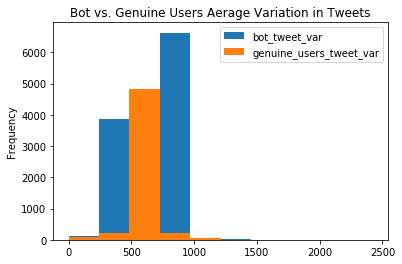

In [109]:
# after filling with mean
df_tweet_var = pd.DataFrame({'bot_tweet_var':levenshtein_data[levenshtein_data.bot==1].tweet_var,
                             'genuine_users_tweet_var': levenshtein_data[levenshtein_data.bot==0].tweet_var})
plt.figure()
df_tweet_var.plot.hist(title='Bot vs. Genuine Users Aerage Variation in Tweets')

### Visualization of Tweet Variance for Human Users and the Bot Users Types

In [110]:
trad_samp_file = os.path.join(DATASETS_DIR,'traditional_spambots_1_sample_lev.csv')
trad_samp = pd.read_csv(trad_samp_file, usecols=['id','tweet_var'])

soc1_samp_file = os.path.join(DATASETS_DIR,'social_spambots_1_sample_lev.csv')
soc1_samp = pd.read_csv(soc1_samp_file, usecols=['id','tweet_var'])

soc2_samp_file = os.path.join(DATASETS_DIR,'social_spambots_2_sample_lev.csv')
soc2_samp = pd.read_csv(soc2_samp_file, usecols=['id','tweet_var'])

soc3_samp_file = os.path.join(DATASETS_DIR,'social_spambots_3_sample_lev.csv')
soc3_samp = pd.read_csv('Datasets/social_spambots_3_sample_lev.csv', usecols=['id','tweet_var'])

fake_samp_file = os.path.join(DATASETS_DIR,'fake_followers_sample_lev.csv')
fake_samp = pd.read_csv(fake_samp_file, usecols=['id','tweet_var'])

human_samp_file = os.path.join(DATASETS_DIR,'human_100_frac0.1_lev.csv')
human_samp = pd.read_csv(human_samp_file, usecols=['id','tweet_var'])

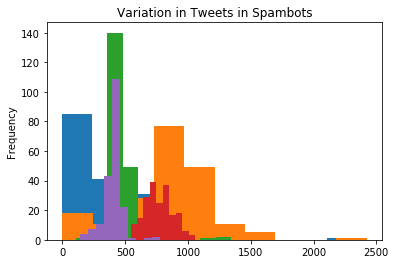

In [111]:
plt.figure()
trad_samp['tweet_var'].plot.hist(title='Variation in Tweets in Spambots')
fake_samp['tweet_var'].plot.hist()
soc1_samp['tweet_var'].plot.hist()
soc2_samp['tweet_var'].plot.hist()
soc3_samp['tweet_var'].plot.hist()

As we can see from the diagram above, most of the bot are out of the range 500 and 750 (roughly)

**statistical information of each bot type**

In [112]:
print('traditional spambots 1:')
print(trad_samp['tweet_var'].describe())
print(' ')
print('fake followers:')
fake_samp['tweet_var'].describe()
print(' ')
print('social spambots 1:')
print(soc1_samp['tweet_var'].describe())
print(' ')
print('social spambots 2:')
print(soc2_samp['tweet_var'].describe())
print(' ')
print('social spambots 3:')
print(soc3_samp['tweet_var'].describe())
print(' ')

traditional spambots 1:
count     200.000000
mean      385.058622
std       404.378679
min         0.000000
25%         0.000000
50%       339.985675
75%       640.328474
max      2341.731794
Name: tweet_var, dtype: float64
 
fake followers:
 
social spambots 1:
count     200.000000
mean      467.622703
std       118.943907
min       109.510938
25%       430.853225
50%       452.060784
75%       483.257234
max      1343.919084
Name: tweet_var, dtype: float64
 
social spambots 2:
count     200.000000
mean      768.363253
std       108.417069
min       542.275574
25%       691.291718
50%       760.613935
75%       840.493483
max      1055.846211
Name: tweet_var, dtype: float64
 
social spambots 3:
count    200.000000
mean     406.735286
std       74.188779
min      137.300949
25%      385.506559
50%      414.055154
75%      440.053096
max      776.997411
Name: tweet_var, dtype: float64
 


count     982.000000
mean      597.920582
std       258.451151
min         0.000000
25%       432.134656
50%       604.751752
75%       764.394582
max      1771.212191
Name: tweet_var, dtype: float64

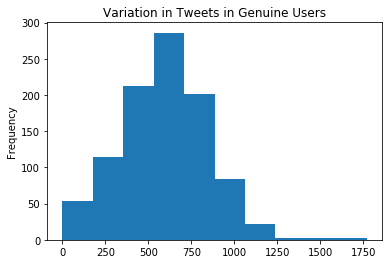

In [113]:
plt.figure()
human_samp['tweet_var'].plot.hist(title='Variation in Tweets in Genuine Users')
human_samp['tweet_var'].describe()

**Adding tweet features to the total data**

In [114]:
total_data = pd.merge(user_data,total_data, how = 'outer')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [115]:
total_data = pd.merge(levenshtein_data,total_data, how = 'outer')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [116]:
total_data = total_data.dropna(subset=['id'])
if 'bot' in total_data.columns or 'tweet_var' in total_data.columns:
    total_data = total_data.dropna(subset=['bot','tweet_var'])

In [117]:
tweet_features = ['p_retweet','p_favorites','p_hashtags','p_urls','p_mentions','avg_tweets_per_hour','500<var<750']

### Tweets - Target Feature Correlation

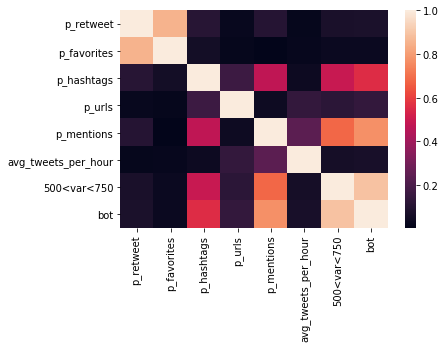

In [118]:
corr_mtx = General_Lib.Plot_Correlation_Matrix(total_data, tweet_features + ['bot'])

In [119]:
corr_mtx['bot']

p_retweet              0.078084
p_favorites            0.034111
p_hashtags             0.559934
p_urls                 0.138514
p_mentions             0.770703
avg_tweets_per_hour    0.067625
500<var<750            0.891961
bot                    1.000000
Name: bot, dtype: float64

In [120]:
tweet_features_for_models = ['p_hashtags','p_mentions','500<var<750']

As we can see, p_hashtags,p_mentions and 500<var<750 are higly correlated to our target feature

## 3.5. Description Feature

Handling 'description' field created the need to translate descriptions to English in order to create BoW - a character limited process . In addition, a long preprocessing process was used in dictionary creation, and running it takes a long time.
Therefore in some sections below we used the 'run_full_process' variable, in order to control running time.

In [121]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
try:
    from yandex.Translater import Translater
except ModuleNotFoundError as e:
    #see if need user flag in university
    !{sys.executable} -m pip install yandex-translater --user 

try:
    from textblob import TextBlob, Word
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install textblob --user
    
try:
    import nltk
except ModuleNotFoundError as e:
    !{sys.executable} -m pip install nltk --user

In [123]:
import Description

In [124]:
if(run_full_process):
    
    nltk.download('punkt')
    nltk.download('wordnet')
    # # # # translating description # # # # #
    description_df = Description.description_trans(total_data)
    # # # # detect language # # # # #
    description_df = Description.add_language_detection(description_df)
    # # # # creating BoW and extracting most important words from it# # # # #
    count_vectors_df, important_words = Description.find_important_words_from_bow(description_df)


### 3.5.1. Description Data

Description data includes original description column, translated description ('translation') and language detection ('description_lang'). We uploaded it, removed unnecessary columns added in csv creation and filled NA with empty string.

In [125]:
len(description_df)

16318

In [126]:
description_df = description_df.drop(['Unnamed: 0'], axis=1)

In [127]:
description_df['description'].fillna('', inplace = True)
description_df['translation'].fillna('', inplace = True)

In [128]:
description_df.head(5)

,id,lang,description,bot,translation,test_set_1,test_set_2,description_lang
0,1502026416,ja,15years ago X.Lines24,0,['15years ago X.Lines24'],0.0,0.0,en
1,2492782375,ja,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),0,['Maintenance apprentice local love. Economics...,0.0,0.0,ja
2,293212315,en,Let me see what your best move is!,0,['Let me see what your best move is!'],0.0,0.0,en
3,191839658,en,20. menna: #farida #nyc and the 80s actually y...,0,['20. menna: #farida #nyc and the 80s actually...,0.0,0.0,en
4,3020965143,en,Cosmetologist,0,['Cosmetologist'],0.0,0.0,en


### 3.5.2. Count Vectors

count vectors data frame includes count of each word in each description (each column is a word in the dictionary). In this section we removed unnecessary column that was created while exporting to csv.

In [129]:
count_vectors_df.head(5)

,Unnamed: 0,main_id,aaaaannndd,ab,abandon,abbbiizzz,abbe,abbindolati,abe,ability,...,티아라,필요에서,ｃａｎｔ,ｆｏｏｄｓ,ｆｕｅｌ,ｍｅｌｔ,test_set_1,test_set_2,is_bot,ｓｔｅｅｌ
0,0,1502026416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
1,1,2492782375,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
2,2,293212315,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
3,3,191839658,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
4,4,3020965143,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


In [130]:
count_vectors_df = count_vectors_df.drop(['Unnamed: 0'], axis=1)

In [131]:
count_vectors_df.head(5)

,main_id,aaaaannndd,ab,abandon,abbbiizzz,abbe,abbindolati,abe,ability,able,...,티아라,필요에서,ｃａｎｔ,ｆｏｏｄｓ,ｆｕｅｌ,ｍｅｌｔ,test_set_1,test_set_2,is_bot,ｓｔｅｅｌ
0,1502026416,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
1,2492782375,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
2,293212315,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
3,191839658,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
4,3020965143,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


### 3.5.3. Extracting Features From Description

#### Basic Feature Extraction

Fetures extracted from description are:

* Count Number of Words In a Description
* Count Number of characters In a Description
* Find Average Word Length in a Description
* Count Number of Stopwords in a Description
* Count Number of Hashtags in a Description
* Count Number of Numerics in a Description
* Count Number of Uppercase Words in a Description

In [132]:
def avg_word(sentence):
    words = sentence.split()
    if(len(words) == 0):
        return 0
    return (sum(len(word) for word in words)/len(words))

In [133]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [134]:
description_df['word_count'] = description_df['description'].apply(lambda x: len(str(x).split(" ")))
description_df['char_count'] = description_df['description'].str.len() ## this also includes spaces
description_df['avg_word'] = description_df['description'].apply(lambda x: avg_word(x))
description_df['stopwords'] = description_df['translation'].apply(lambda x: len([x for x in x.split() if x in stop]))
description_df['hashtags'] = description_df['description'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
description_df['numerics'] = description_df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
description_df['upper'] = description_df['translation'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
description_df[['translation','word_count','char_count','avg_word','stopwords','hashtags','numerics','upper']].head()

,translation,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper
0,['15years ago X.Lines24'],3,21,6.333333,0,0,0,0
1,['Maintenance apprentice local love. Economics...,3,48,15.333333,3,0,0,0
2,['Let me see what your best move is!'],8,34,3.375000,3,0,0,0
3,['20. menna: #farida #nyc and the 80s actually...,11,58,4.363636,3,2,0,0
4,['Cosmetologist'],1,13,13.000000,0,0,0,0


#### Important Words

Important words is a list of 10 most important wotds that were extracted from BoW process

In [135]:
if(not run_full_process):
    important_words = ['job','lover','love','student','life','follow','instagram','thing','italy','live']

In [136]:
important_words_df = count_vectors_df[np.concatenate((['main_id'], important_words), axis=None)]

In [137]:
important_words_df.head(10)

,main_id,job,lover,love,student,life,follow,instagram,thing,italy,live
0,1502026416,0,0,0,0,0,0,0,0,0,0
1,2492782375,0,0,1,0,0,0,0,0,0,0
2,293212315,0,0,0,0,0,0,0,0,0,0
3,191839658,0,0,0,0,0,0,0,0,0,0
4,3020965143,0,0,0,0,0,0,0,0,0,0
5,2157382005,0,0,0,0,0,0,0,0,0,0
6,1947320929,0,0,0,0,0,0,0,0,0,0
7,255846106,0,0,0,1,0,0,0,0,0,0
8,1733095801,0,0,0,0,0,0,0,0,0,0
9,1336097480,0,0,0,0,0,0,0,0,0,0


Merging word count vectors with basic description features

In [138]:
description_df = description_df.merge(important_words_df, left_on="id",right_on="main_id")

In [139]:
description_df.drop(["main_id"],axis=1,inplace=True)

In [140]:
description_df = description_df.rename(index=str, columns={"job": "job_appearances", "lover": "lover_appearances", "love": "love_appearances",
                                          "student": "student_appearances", "life": "life_appearances", "follow": "follow_appearances",
                                          "instagram": "instagram_appearances", "thing": "thing_appearances","italy": "italy_appearances", 
                                          "live": "live_appearances"})

#### Add 'contains_url'

If 'http' appeared in a description we mared a description as one that containes a URL

In [141]:
count_vectors_df['http'] = count_vectors_df['http'].reset_index(drop=True)
description_df['contains_url'] = 0
description_df['contains_url'] = description_df['contains_url'].reset_index(drop=True)
count_vectors_df['http'].index = description_df['contains_url'].index

In [142]:
description_df['contains_url'] = count_vectors_df['http'].apply(lambda x: 1 if x > 0 else 0)

In [143]:
description_df['contains_url'].unique()

array([0, 1], dtype=int64)

#### Add Language Difference

Using 'description_lang' which was added to 'description_df' with Yandex service of language detection. If 'description_lang' is different from an account's language ('lang') it was marked with '1', otherwise '0'.

In [144]:
description_df['different_lang'] = description_df['description_lang'] == description_df['lang']
description_df['different_lang'] = description_df['different_lang'].apply(lambda x: 1 if x else 0)

In [145]:
description_df['different_lang'].unique()

array([0, 1], dtype=int64)

### 3.5.4. Description Features Visualization

**Calculating Pearson Correlation**

In [146]:
description_df.columns

Index(['id', 'lang', 'description', 'bot', 'translation', 'test_set_1',
       'test_set_2', 'description_lang', 'word_count', 'char_count',
       'avg_word', 'stopwords', 'hashtags', 'numerics', 'upper',
       'job_appearances', 'lover_appearances', 'love_appearances',
       'student_appearances', 'life_appearances', 'follow_appearances',
       'instagram_appearances', 'thing_appearances', 'italy_appearances',
       'live_appearances', 'contains_url', 'different_lang'],
      dtype='object')

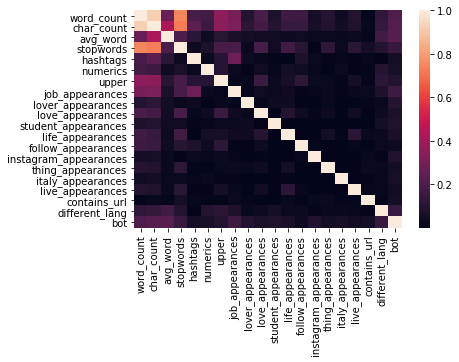

In [147]:
features_for_correlation = ['word_count','char_count','avg_word','stopwords','hashtags','numerics',
                        'upper','job_appearances','lover_appearances','love_appearances',
                        'student_appearances','life_appearances', 'follow_appearances', 'instagram_appearances',
                        'thing_appearances', 'italy_appearances', 'live_appearances', 'contains_url',
                        'different_lang','bot']

corr_mtx = General_Lib.Plot_Correlation_Matrix(description_df,features_for_correlation)

In [205]:
corr_mtx['bot']

word_count               0.204636
char_count               0.223448
avg_word                 0.231802
stopwords                0.146455
hashtags                 0.051877
numerics                 0.065483
upper                    0.090484
job_appearances          0.159020
lover_appearances        0.096801
love_appearances         0.072153
student_appearances      0.079392
life_appearances         0.067299
follow_appearances       0.033892
instagram_appearances    0.084680
thing_appearances        0.049061
italy_appearances        0.060783
live_appearances         0.044462
contains_url             0.054179
different_lang           0.149087
bot                      1.000000
Name: bot, dtype: float64

#### Important Features Distribution

In [148]:
print("Number of spambots containing the word 'job' is"
      ,description_df[description_df.bot==1]['job_appearances'].apply(lambda x: 1 if x > 0 else 0).sum() ,
      "and number of genuine accounts containing 'job' is",
      description_df[description_df.bot==0]['job_appearances'].apply(lambda x: 1 if x > 0 else 0).sum())

Number of spambots containing the word 'job' is 1392 and number of genuine accounts containing 'job' is 15


In [149]:
print("Number of spambots containing the word 'follow' is",
      description_df[description_df.bot==1]['follow_appearances'].apply(lambda x: 1 if x > 0 else 0).sum() ,
      "and number of genuine accounts containing 'follow' is",
      description_df[description_df.bot==0]['follow_appearances'].apply(lambda x: 1 if x > 0 else 0).sum())

Number of spambots containing the word 'follow' is 279 and number of genuine accounts containing 'follow' is 84


In [150]:
print("Number of accounts with different language than declared is:", description_df[description_df.bot==0]['different_lang'].sum())

Number of accounts with different language than declared is: 4519


#### Merge Final Description Features with Total Data

In [151]:
description_features = ['id','word_count','char_count','avg_word','stopwords','hashtags','numerics',
                        'upper','job_appearances','lover_appearances','love_appearances',
                        'student_appearances','life_appearances', 'follow_appearances', 'instagram_appearances',
                        'thing_appearances', 'italy_appearances', 'live_appearances', 'contains_url', 'different_lang']

In [152]:
description_features_for_model = ['word_count','avg_word','stopwords','job_appearances','follow_appearances','different_lang']

In [153]:
description_df[description_features].head(5)

,id,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,job_appearances,lover_appearances,love_appearances,student_appearances,life_appearances,follow_appearances,instagram_appearances,thing_appearances,italy_appearances,live_appearances,contains_url,different_lang
0,1502026416,3,21,6.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2492782375,3,48,15.333333,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,293212315,8,34,3.375000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,191839658,11,58,4.363636,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3020965143,1,13,13.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [154]:
total_data = pd.merge(description_df[description_features],total_data, how = 'outer')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [155]:
total_data.shape

(16318, 158)

In [156]:
total_data.dtypes

id                                               object
word_count                                        int64
char_count                                        int64
avg_word                                        float64
stopwords                                         int64
hashtags                                          int64
numerics                                          int64
upper                                             int64
job_appearances                                   int64
lover_appearances                                 int64
love_appearances                                  int64
student_appearances                               int64
life_appearances                                  int64
follow_appearances                                int64
instagram_appearances                             int64
thing_appearances                                 int64
italy_appearances                                 int64
live_appearances                                

# 4. Data Visualization & Analysis

**Most visualization work is done on each part above**

## 4.1. Correlations

On the section below we choose user features with the highest correlation to target. For tweets and description features we chose high correlated features above.

### Target - Feature Correlations: User Features

In [157]:
methods = ['pearson', 'kendall', 'spearman']
features_list_to_drop = tweet_features + description_features + ['bot']
General_Lib.Print_Target_Features_Correlation(total_data, 
                                              methods, 
                                              'bot', 
                                              features_list_to_drop)

---------------Target - Feature Correlations---------------

*** pearson best 10 correlation results ***
is_favourite -0.8213190694808827
statuses_count_binning -0.7152237317990724
profile_banner_url_len -0.6334670314652076
profile_banner_url_most_common 0.6308267000370438
bin_followers_count -0.5266178365117588
geo_enabled -0.4850199497669231
time_zone_most_common 0.43609469098969944
is_top_month 0.3797496310780204
profile_background_color_unique_dist 0.3727125349041029
is_utc_offset -0.3696063648983339
time_zone_unique -0.36857292506672146

*** kendall best 10 correlation results ***
is_favourite -0.8213190694808825
favourites_count -0.7844299933781393
statuses_count_binning -0.6877574852658319
profile_banner_url_most_common 0.6308267000370429
profile_banner_url_len -0.6085600600354579
statuses_count -0.5342907031773665
geo_enabled -0.4850199497669217
bin_followers_count -0.47066705357482563
profile_banner_url_unique -0.4523520153379925
profile_banner_url_unique_mode -0.4523520153379

In [158]:
top_base_correlated_features = ['is_favourite', 
                                'statuses_count_binning',
                                'bin_followers_count', 
                                'profile_background_color_unique_dist',
                                'is_utc_offset',
                                'is_top_month',
                                'geo_enabled',
                                'time_zone_most_common',
                                'profile_banner_url_len']

In [159]:
total_features_to_use = top_base_correlated_features + tweet_features_for_models + description_features_for_model

# 5. Data Division

Dividing data by binary columns 'test_set_1' (we use it as validation set) and 'test_set_2' (we use it by test set). When marked with '1' an account belongs to a test set, otherwise, belongs to training set.

In [160]:
train_data, test_set_1, test_set_2 = General_Lib.train_test_division(total_data)

# 6. Model

**Dividing train data into X values and y values**

In [161]:
y_train = train_data['bot']
x_train = train_data[total_features_to_use]

## 6.1. Decision Trees

In [162]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
DTclassifier = DecisionTreeClassifier(criterion='entropy', class_weight = {0:1,1:2})  
DTclassifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 6.2. Random forest

In [163]:
from sklearn.ensemble import RandomForestRegressor
RFclassifier = RandomForestRegressor(n_estimators=20, random_state=0)  
RFclassifier.fit(x_train, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [164]:
feature_importances = pd.DataFrame(RFclassifier.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [165]:
feature_importances

,importance
500<var<750,0.779561
p_mentions,0.077339
profile_background_color_unique_dist,0.028848
p_hashtags,0.021604
avg_word,0.021510
is_utc_offset,0.020734
profile_banner_url_len,0.014308
word_count,0.012746
is_favourite,0.005248
statuses_count_binning,0.005080


## 6.3. Naive Bayes

In [166]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [167]:
NBclassifier.theta_ 

array([[9.39195298e-01, 2.76898734e+00, 4.44552441e+00, 8.03770344e+01,
        4.32188065e-01, 3.52848101e-01, 5.61030741e-01, 2.75768535e-01,
        4.53013110e+01, 4.43769319e-01, 7.78425445e-01, 8.78390597e-01,
        1.15804702e+01, 5.48874180e+00, 3.08679928e+00, 3.39059675e-03,
        1.62748644e-02, 8.17811935e-01],
       [7.63852103e-02, 1.21633648e+00, 2.28668291e+00, 4.28634707e+02,
        1.01705689e-02, 7.43616909e-01, 1.32429283e-01, 8.23180422e-01,
        9.78408730e+00, 1.31112989e-01, 2.21668247e-01, 1.71628350e-02,
        7.17152241e+00, 2.55151104e+00, 1.61680263e+00, 2.02140057e-01,
        3.33721793e-02, 9.27216866e-01]])

## 6.4. Logistic Resression

In [168]:
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression()
LRclassifier.fit(x_train, y_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [169]:
LRclassifier.coef_ 

array([[-1.88506616e+00, -1.74959232e-01,  6.97095854e-02,
         2.42890405e-03, -1.23152731e+00,  8.36370593e-01,
        -6.01384630e-01,  1.22943236e+00, -3.49710474e-02,
        -1.41048052e+00, -2.16034729e+00, -4.75184532e+00,
         3.55975670e-02, -1.96385645e-02, -1.58788613e-01,
         1.89632460e+00,  2.42927499e-01,  1.21728920e+00]])

# 7. Model Evaluation

In [170]:
import Evaluation_Results_Lib
results_analyzer = False
compare_results = False

**Dividing validation and test data into X values and y values**

In [171]:
y_validation = test_set_1['bot']
x_validation = test_set_1[total_features_to_use]

In [172]:
y_test = test_set_2['bot']
x_test = test_set_2[total_features_to_use]

## 7.1. Decision Trees

### 7.1.1. Validation Set

In [173]:
y_pred_descisionTree = DTclassifier.predict(x_validation)  
y_pred_descisionTree_probs = DTclassifier.predict_proba(x_validation)

In [174]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_descisionTree, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Decision_Tree')

Confusion Matrix :
[[992   8]
 [ 92 899]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1000
           1       0.99      0.91      0.95       991

   micro avg       0.95      0.95      0.95      1991
   macro avg       0.95      0.95      0.95      1991
weighted avg       0.95      0.95      0.95      1991

Accuracy :  0.9497739829231542
MCC :  0.9027296047427779
Specificity :  0.9071644803229062


### 7.1.2. Test Set

In [175]:
y_pred_descisionTree_test = DTclassifier.predict(x_test)  
y_pred_descisionTree_probs_test = DTclassifier.predict_proba(x_test)

In [176]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_descisionTree_test, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Decision_Tree')

Confusion Matrix :
[[486   4]
 [ 21 443]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9737945492662474
MCC :  0.948103495846641
Specificity :  0.9547413793103449


## 7.2. Random forest

### 7.2.1. Validation Set

In [177]:
# Random forest
y_pred_forest = RFclassifier.predict(x_validation)
y_pred_forest_probs = y_pred_forest

In [178]:
y_pred_forest = y_pred_forest >=0.5
y_pred_forest = y_pred_forest.astype(int)

In [179]:
np.unique(y_pred_forest)

array([0, 1])

In [180]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_forest, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Random_Forest')

Confusion Matrix :
[[995   5]
 [ 52 939]]
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.99      0.95      0.97       991

   micro avg       0.97      0.97      0.97      1991
   macro avg       0.97      0.97      0.97      1991
weighted avg       0.97      0.97      0.97      1991

Accuracy :  0.9713711702661979
MCC :  0.9437818796364495
Specificity :  0.9475277497477296


### 7.2.2. Test Set

In [181]:
# Random forest
y_pred_forest_test = RFclassifier.predict(x_test)
y_pred_forest_probs_test = y_pred_forest_test

In [182]:
y_pred_forest_test = y_pred_forest_test >=0.5
y_pred_forest_test = y_pred_forest_test.astype(int)

In [183]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_forest_test, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Random_Forest')

Confusion Matrix :
[[486   4]
 [ 22 442]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9727463312368972
MCC :  0.9460721825249041
Specificity :  0.9525862068965517


## 7.3. Naive Bayes

### 7.3.1 Validation Set

In [184]:
y_pred_nb = NBclassifier.predict(x_validation)
y_pred_nb_probs = NBclassifier.predict_proba(x_validation)

In [185]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_nb, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Naive_Bayes')

Confusion Matrix :
[[998   2]
 [911  80]]
Classification Report :
              precision    recall  f1-score   support

           0       0.52      1.00      0.69      1000
           1       0.98      0.08      0.15       991

   micro avg       0.54      0.54      0.54      1991
   macro avg       0.75      0.54      0.42      1991
weighted avg       0.75      0.54      0.42      1991

Accuracy :  0.5414364640883977
MCC :  0.19808340613654948
Specificity :  0.08072653884964683


### 7.3.2 Test Set

In [186]:
y_pred_nb_test = NBclassifier.predict(x_test)
y_pred_nb_probs_test = NBclassifier.predict_proba(x_test)

In [187]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_nb_test, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Naive_Bayes')

Confusion Matrix :
[[489   1]
 [220 244]]
Classification Report :
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       490
           1       1.00      0.53      0.69       464

   micro avg       0.77      0.77      0.77       954
   macro avg       0.84      0.76      0.75       954
weighted avg       0.84      0.77      0.75       954

Accuracy :  0.7683438155136268
MCC :  0.5992857972802867
Specificity :  0.5258620689655172


## 7.4. Logistic regression

### 7.4.1. Validation Set

In [188]:
y_pred_lr = LRclassifier.predict(x_validation)
y_pred_lr_probs = LRclassifier.predict_proba(x_validation)

In [189]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     y_pred_lr, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Logistic_Regression')

Confusion Matrix :
[[994   6]
 [ 56 935]]
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.99      0.94      0.97       991

   micro avg       0.97      0.97      0.97      1991
   macro avg       0.97      0.97      0.97      1991
weighted avg       0.97      0.97      0.97      1991

Accuracy :  0.9688598694123556
MCC :  0.9388899038917626
Specificity :  0.9434914228052472


### 7.4.2. Test Set

In [190]:
y_pred_lr_test = LRclassifier.predict(x_test)
y_pred_lr_probs_test = LRclassifier.predict_proba(x_test)

In [191]:
Evaluation_Results_Lib.print_results(y_test, 
                                     y_pred_lr_test, 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Logistic_Regression')

Confusion Matrix :
[[486   4]
 [ 21 443]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       490
           1       0.99      0.95      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9737945492662474
MCC :  0.948103495846641
Specificity :  0.9547413793103449


## 7.5. Collective Model

This model classifies by the majority in all models

### 7.5.1. Validation Set

In [192]:
res_dict = {'Decision_Trees':y_pred_descisionTree, 
            'Random_Forest':y_pred_forest, 
            'Naive_bayes':y_pred_nb,
            'LG':y_pred_lr
           }

results = pd.DataFrame(data = res_dict)
results['Collective_Model'] = results.mode(axis = 1)[0]

In [193]:
Evaluation_Results_Lib.print_results(y_validation, 
                                     results['Collective_Model'], 
                                     analyze_results = False, 
                                     classifier_name = 'Collective_Model')

Confusion Matrix :
[[998   2]
 [109 882]]
Classification Report :
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1000
           1       1.00      0.89      0.94       991

   micro avg       0.94      0.94      0.94      1991
   macro avg       0.95      0.94      0.94      1991
weighted avg       0.95      0.94      0.94      1991

Accuracy :  0.9442491210447012
MCC :  0.8936239199266683
Specificity :  0.8900100908173562


### 7.5.2. Test Set

In [194]:
res_dict_test = {'Decision_Trees':y_pred_descisionTree_test, 
                 'Random_Forest':y_pred_forest_test, 
                 'Naive_bayes':y_pred_nb_test,
                 'LG':y_pred_lr_test
                }

results_test = pd.DataFrame(data = res_dict_test)
results_test['Collective_Model'] = results_test.mode(axis = 1)[0]

In [195]:
Evaluation_Results_Lib.print_results(y_test, 
                                     results_test['Collective_Model'], 
                                     analyze_results = results_analyzer, 
                                     classifier_name = 'Collective_Model')

Confusion Matrix :
[[488   2]
 [ 27 437]]
Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       490
           1       1.00      0.94      0.97       464

   micro avg       0.97      0.97      0.97       954
   macro avg       0.97      0.97      0.97       954
weighted avg       0.97      0.97      0.97       954

Accuracy :  0.9696016771488469
MCC :  0.9403691421023607
Specificity :  0.9418103448275862


## 7.6. ROC\AUC

### 7.6.1 Validation Set 

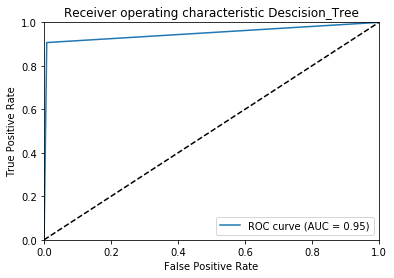

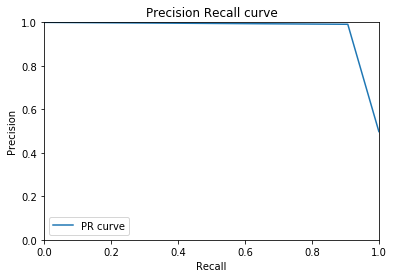

In [196]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_descisionTree_probs[:,1], 
                                    'Descision_Tree')

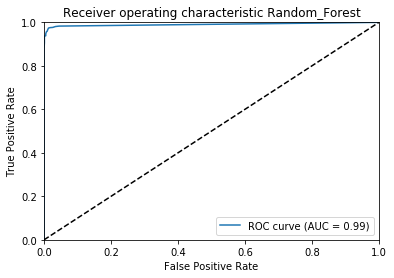

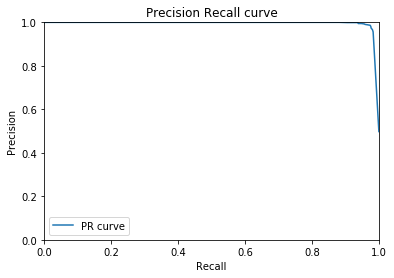

In [197]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_forest_probs, 
                                    'Random_Forest')

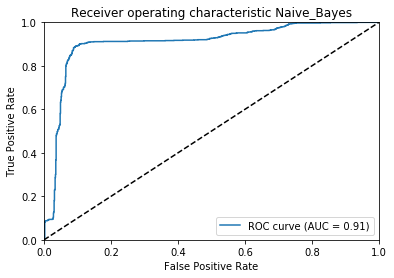

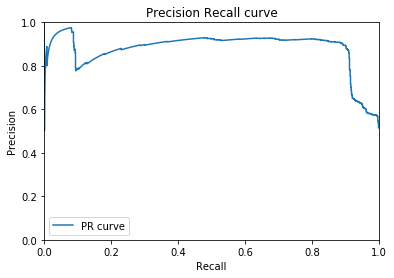

In [198]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_nb_probs[:,1], 
                                    'Naive_Bayes')

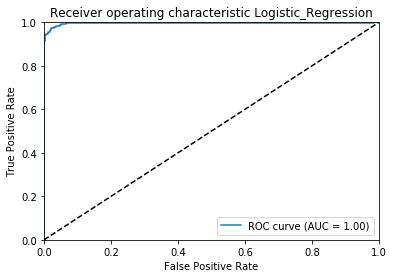

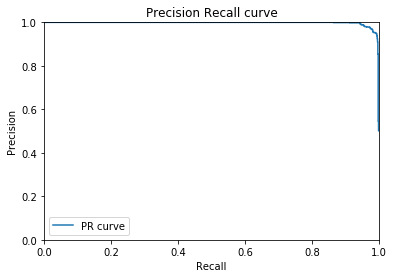

In [199]:
Evaluation_Results_Lib.Plot_Metrics(y_validation,
                                    y_pred_lr_probs[:,1], 
                                    'Logistic_Regression')

### 7.6.2. Test Set 

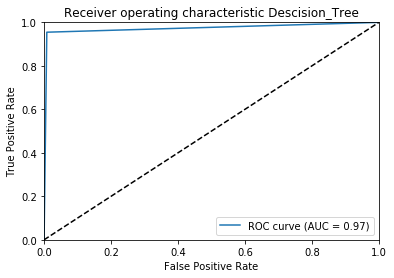

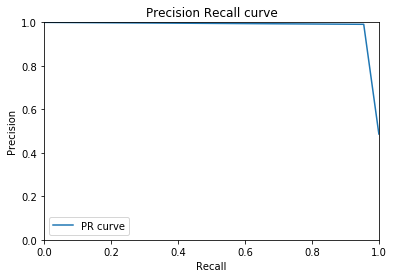

In [200]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_descisionTree_probs_test[:,1], 
                                    'Descision_Tree')

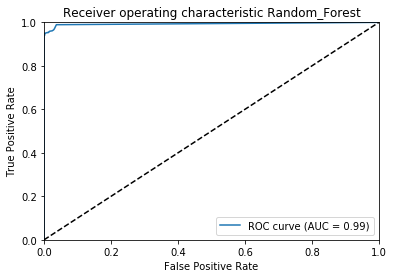

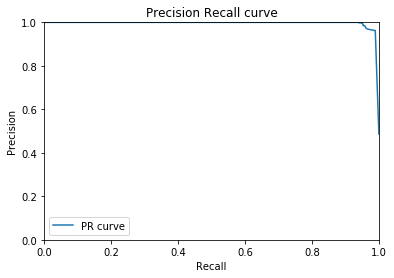

In [201]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_forest_probs_test, 
                                    'Random_Forest')

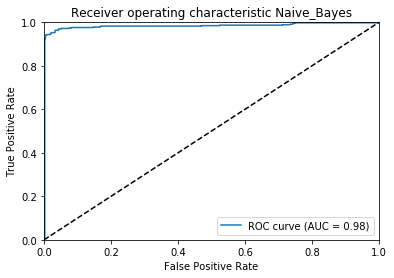

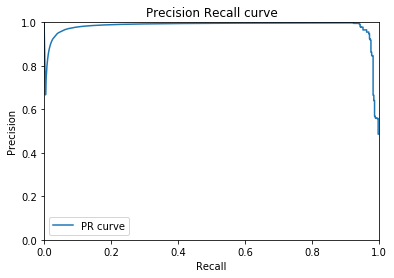

In [202]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_nb_probs_test[:,1], 
                                    'Naive_Bayes')

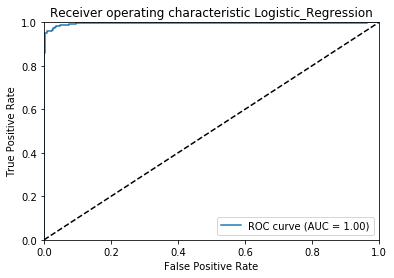

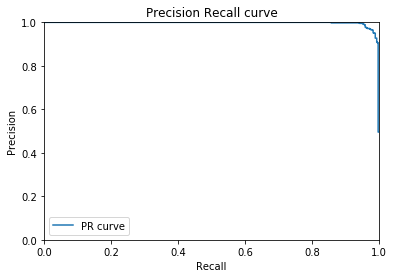

In [203]:
Evaluation_Results_Lib.Plot_Metrics(y_test,
                                    y_pred_lr_probs_test[:,1], 
                                    'Logistic_Regression')

# 7.7. Robustness Test : K-Fold

Cross-validation with the model that yields the best results : **Random Forest**

In [204]:
kfold = KFold(n_splits=10, shuffle = True)
rfc = RandomForestRegressor(n_estimators=20, random_state=0)
for train_indices, test_indices in kfold.split(x_train):
    rfc.fit(x_train.iloc[train_indices], y_train.iloc[train_indices])
    y_pred = rfc.predict(x_train.iloc[test_indices])
    y_pred = y_pred >=0.5
    y_pred = y_pred.astype(int)
    Evaluation_Results_Lib.print_results(y_train.iloc[test_indices], y_pred, 
              analyze_results = results_analyzer, classifier_name = 'Random Forest')
    print("------------------------------------------------------------------------")

Confusion Matrix :
[[414  10]
 [ 10 953]]
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       424
           1       0.99      0.99      0.99       963

   micro avg       0.99      0.99      0.99      1387
   macro avg       0.98      0.98      0.98      1387
weighted avg       0.99      0.99      0.99      1387

Accuracy :  0.9855803893294881
MCC :  0.96603087834793
Specificity :  0.9896157840083074
------------------------------------------------------------------------
Confusion Matrix :
[[420   9]
 [ 18 940]]
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       429
           1       0.99      0.98      0.99       958

   micro avg       0.98      0.98      0.98      1387
   macro avg       0.97      0.98      0.98      1387
weighted avg       0.98      0.98      0.98      1387

Accuracy :  0.9805335255948089
MCC :  0.954810836621

As seen above, results are consistent for each fold, hence the best model is robust. 